In [291]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

In [292]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [293]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [294]:
data = pd.read_csv('/content/TSLA.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000
1,2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000
2,2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000
3,2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000
4,2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000


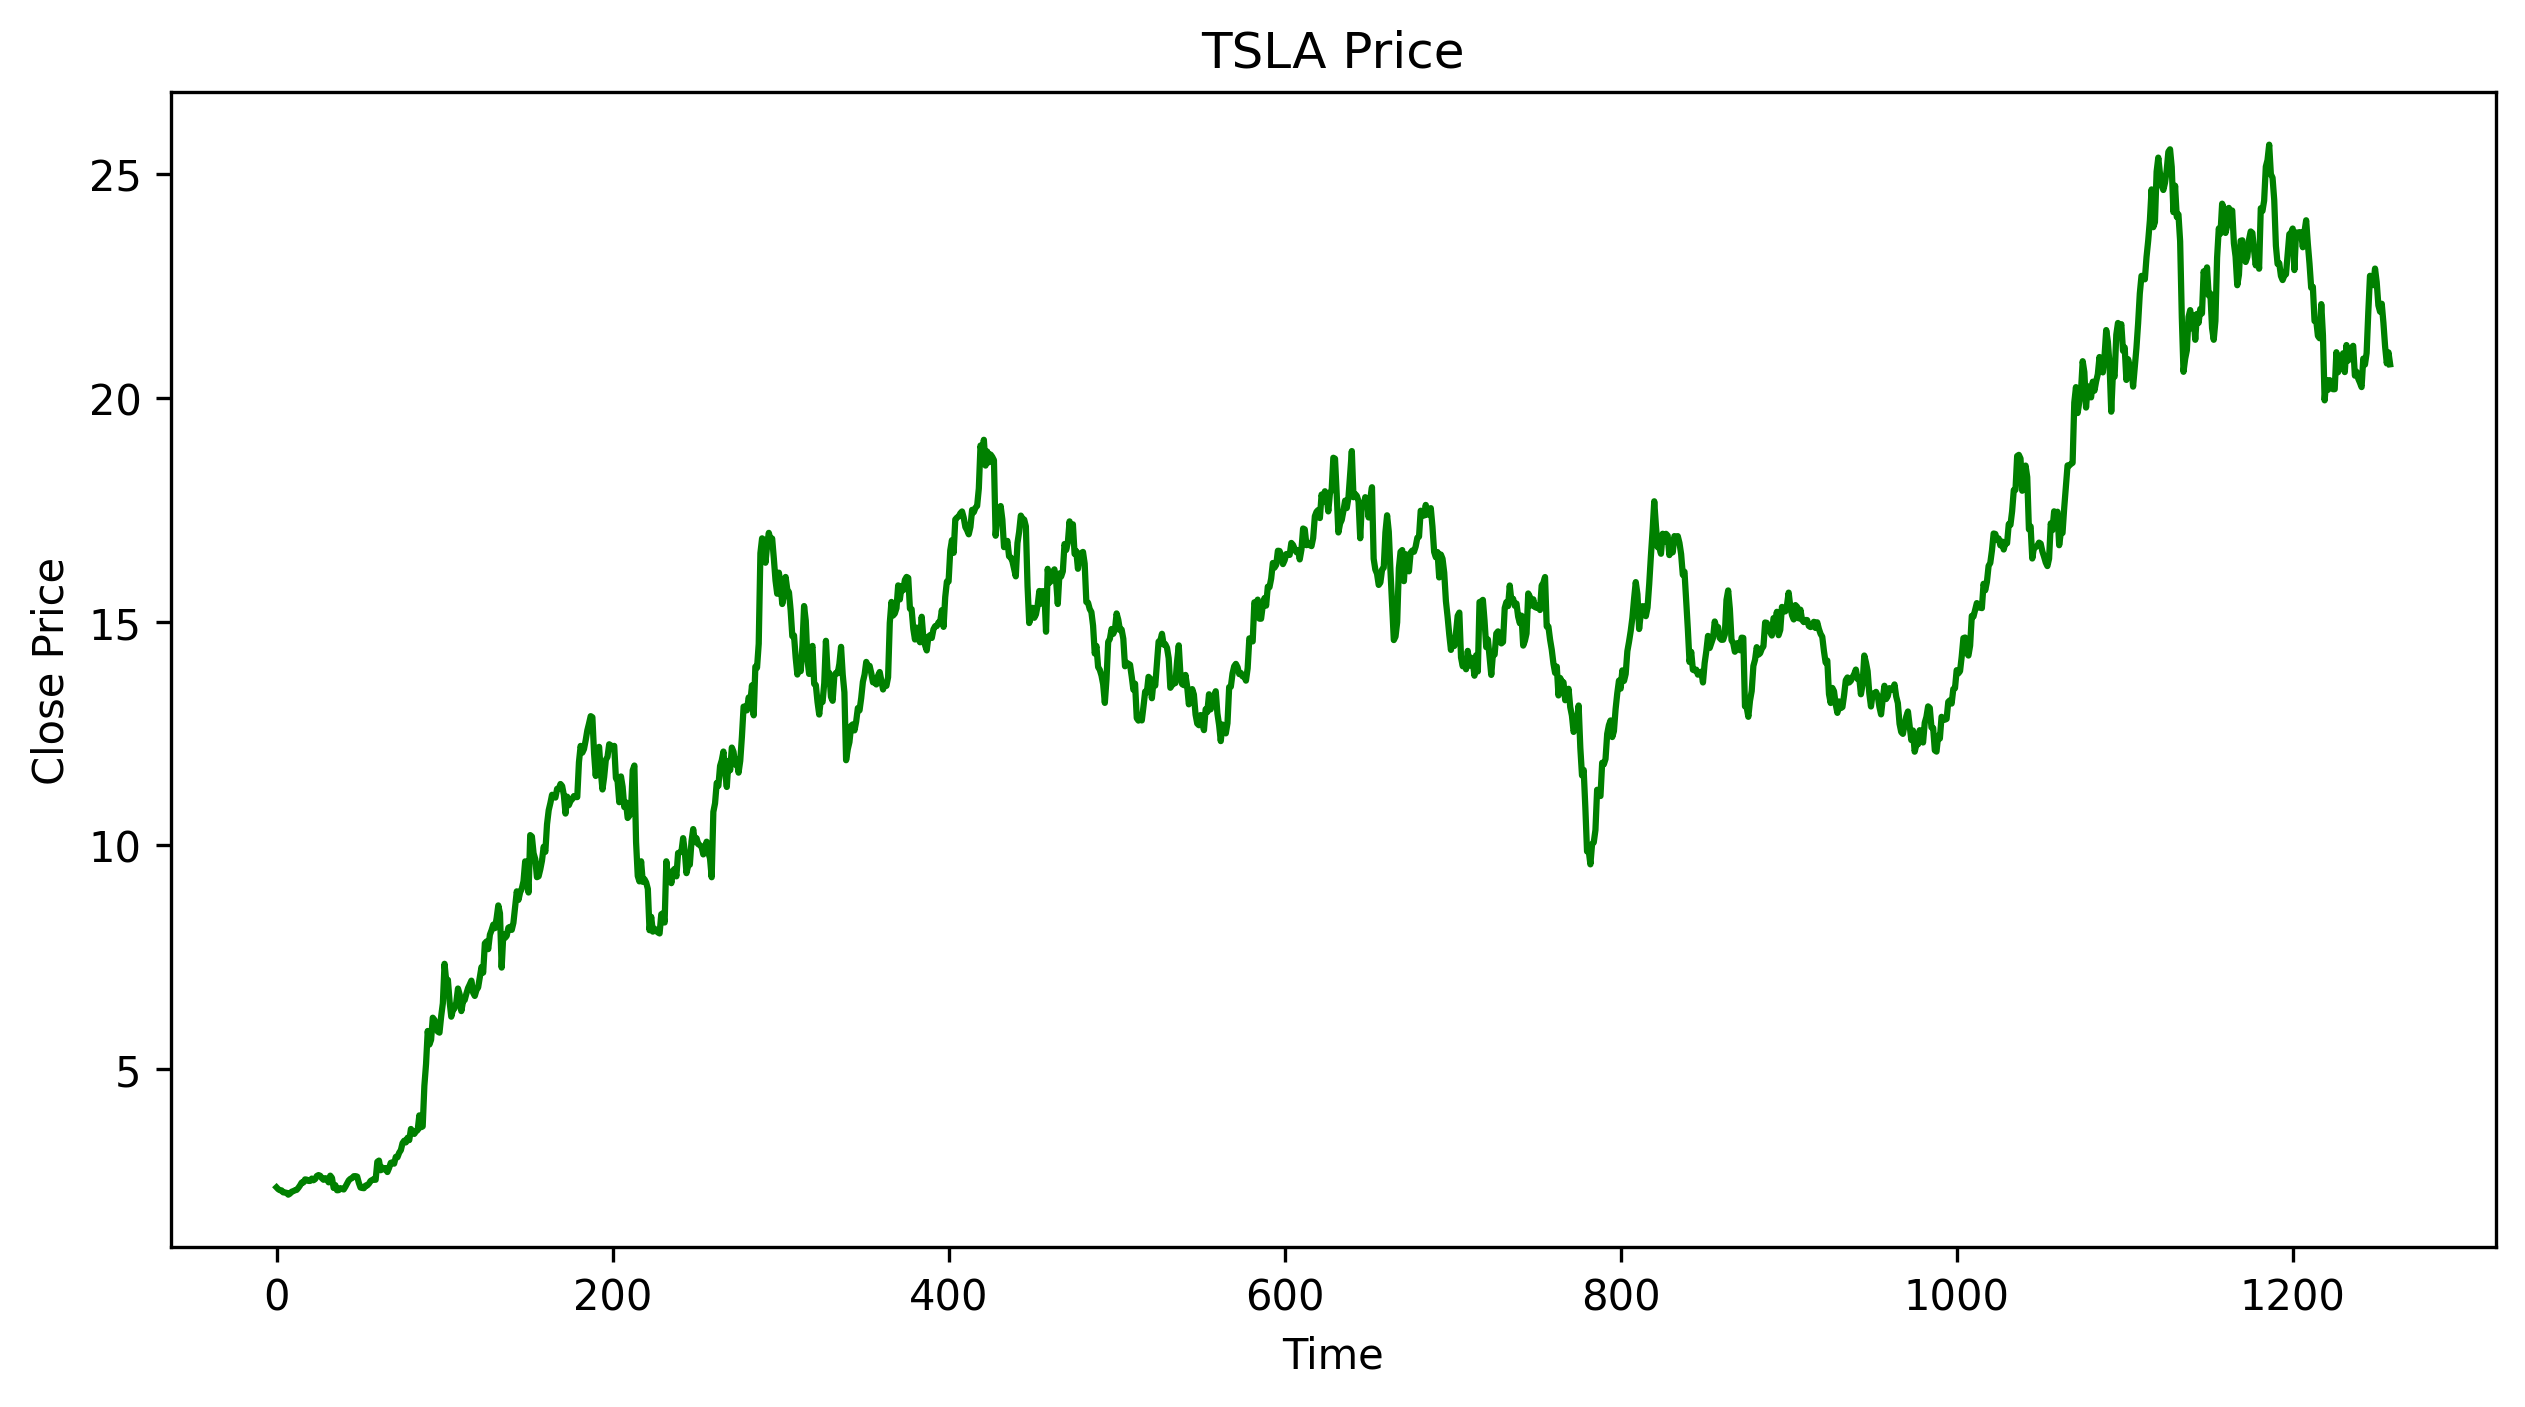

In [295]:
data=data['Close']
plt.figure(figsize=(10,5),dpi=300)
plt.plot(data, color ='green')
plt.ylabel('Close Price')
plt.title('TSLA Price')
plt.xlabel('Time')
plt.show()

In [296]:
# 共1259筆
split =int(0.8*data.shape[0])
Train,Test  = data[0:split] , data[split:]

val_split=int(0.8*Train.shape[0])
Train,Val=Train[0:val_split] , Train[val_split:]
Val=Val.reset_index(drop=True)
Test=Test.reset_index(drop=True)
split

1007

In [297]:
sc = MinMaxScaler(feature_range = (0, 1))
#需將資料做reshape的動作，使其shape為(資料長度,1)
train_set= Train.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(train_set)
val_set= Val.values.reshape(-1,1)
val_set_scaled = sc.transform(val_set)
test_set = Test.values.reshape(-1,1)
test_set_scaled = sc.transform(test_set)

X_train = []
y_train = []
for i in range(3,len(train_set)):
    X_train.append(training_set_scaled[i-3:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))

X_val = []
y_val = []
for i in range(3,len(val_set)):
    X_val.append(val_set_scaled[i-3:i])
    y_val.append(val_set_scaled[i])
X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val,(X_val.shape[0], X_val.shape[1], 1))

X_test = []
y_test = []
for i in range(3,len(test_set)):
    X_test.append(test_set_scaled[i-3:i])
    y_test.append(test_set_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

In [298]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
# from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

In [299]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

# Simple RNN

# Fit & compile the model

In [ ]:
keras.backend.clear_session()
# Build RNN+DNN Model
model = Sequential()
model.add(layers.SimpleRNN(20,
            input_shape=(3, 1),
            activation='linear'))
model.add(Dense(units=1, activation='linear'))
model.summary()

# Compile Model
opt=Adam(learning_rate=0.005,beta_1=0.99)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                440       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64,validation_data=(X_val,y_val))

Epoch 1/100
13/13 [==============================] - 1s 28ms/step - loss: 0.1144 - mean_absolute_percentage_error: 53086.3242 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 4.6439
Epoch 2/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0612 - mean_absolute_percentage_error: 15578.1475 - val_loss: 0.0782 - val_mean_absolute_percentage_error: 10.8386
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0558 - mean_absolute_percentage_error: 10487.8643 - val_loss: 0.0505 - val_mean_absolute_percentage_error: 7.1102
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0456 - mean_absolute_percentage_error: 14369.1807 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 4.6070
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0408 - mean_absolute_percentage_error: 8221.8262 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 3.8347
Epoch 6/100
13/13 [==============================]

In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

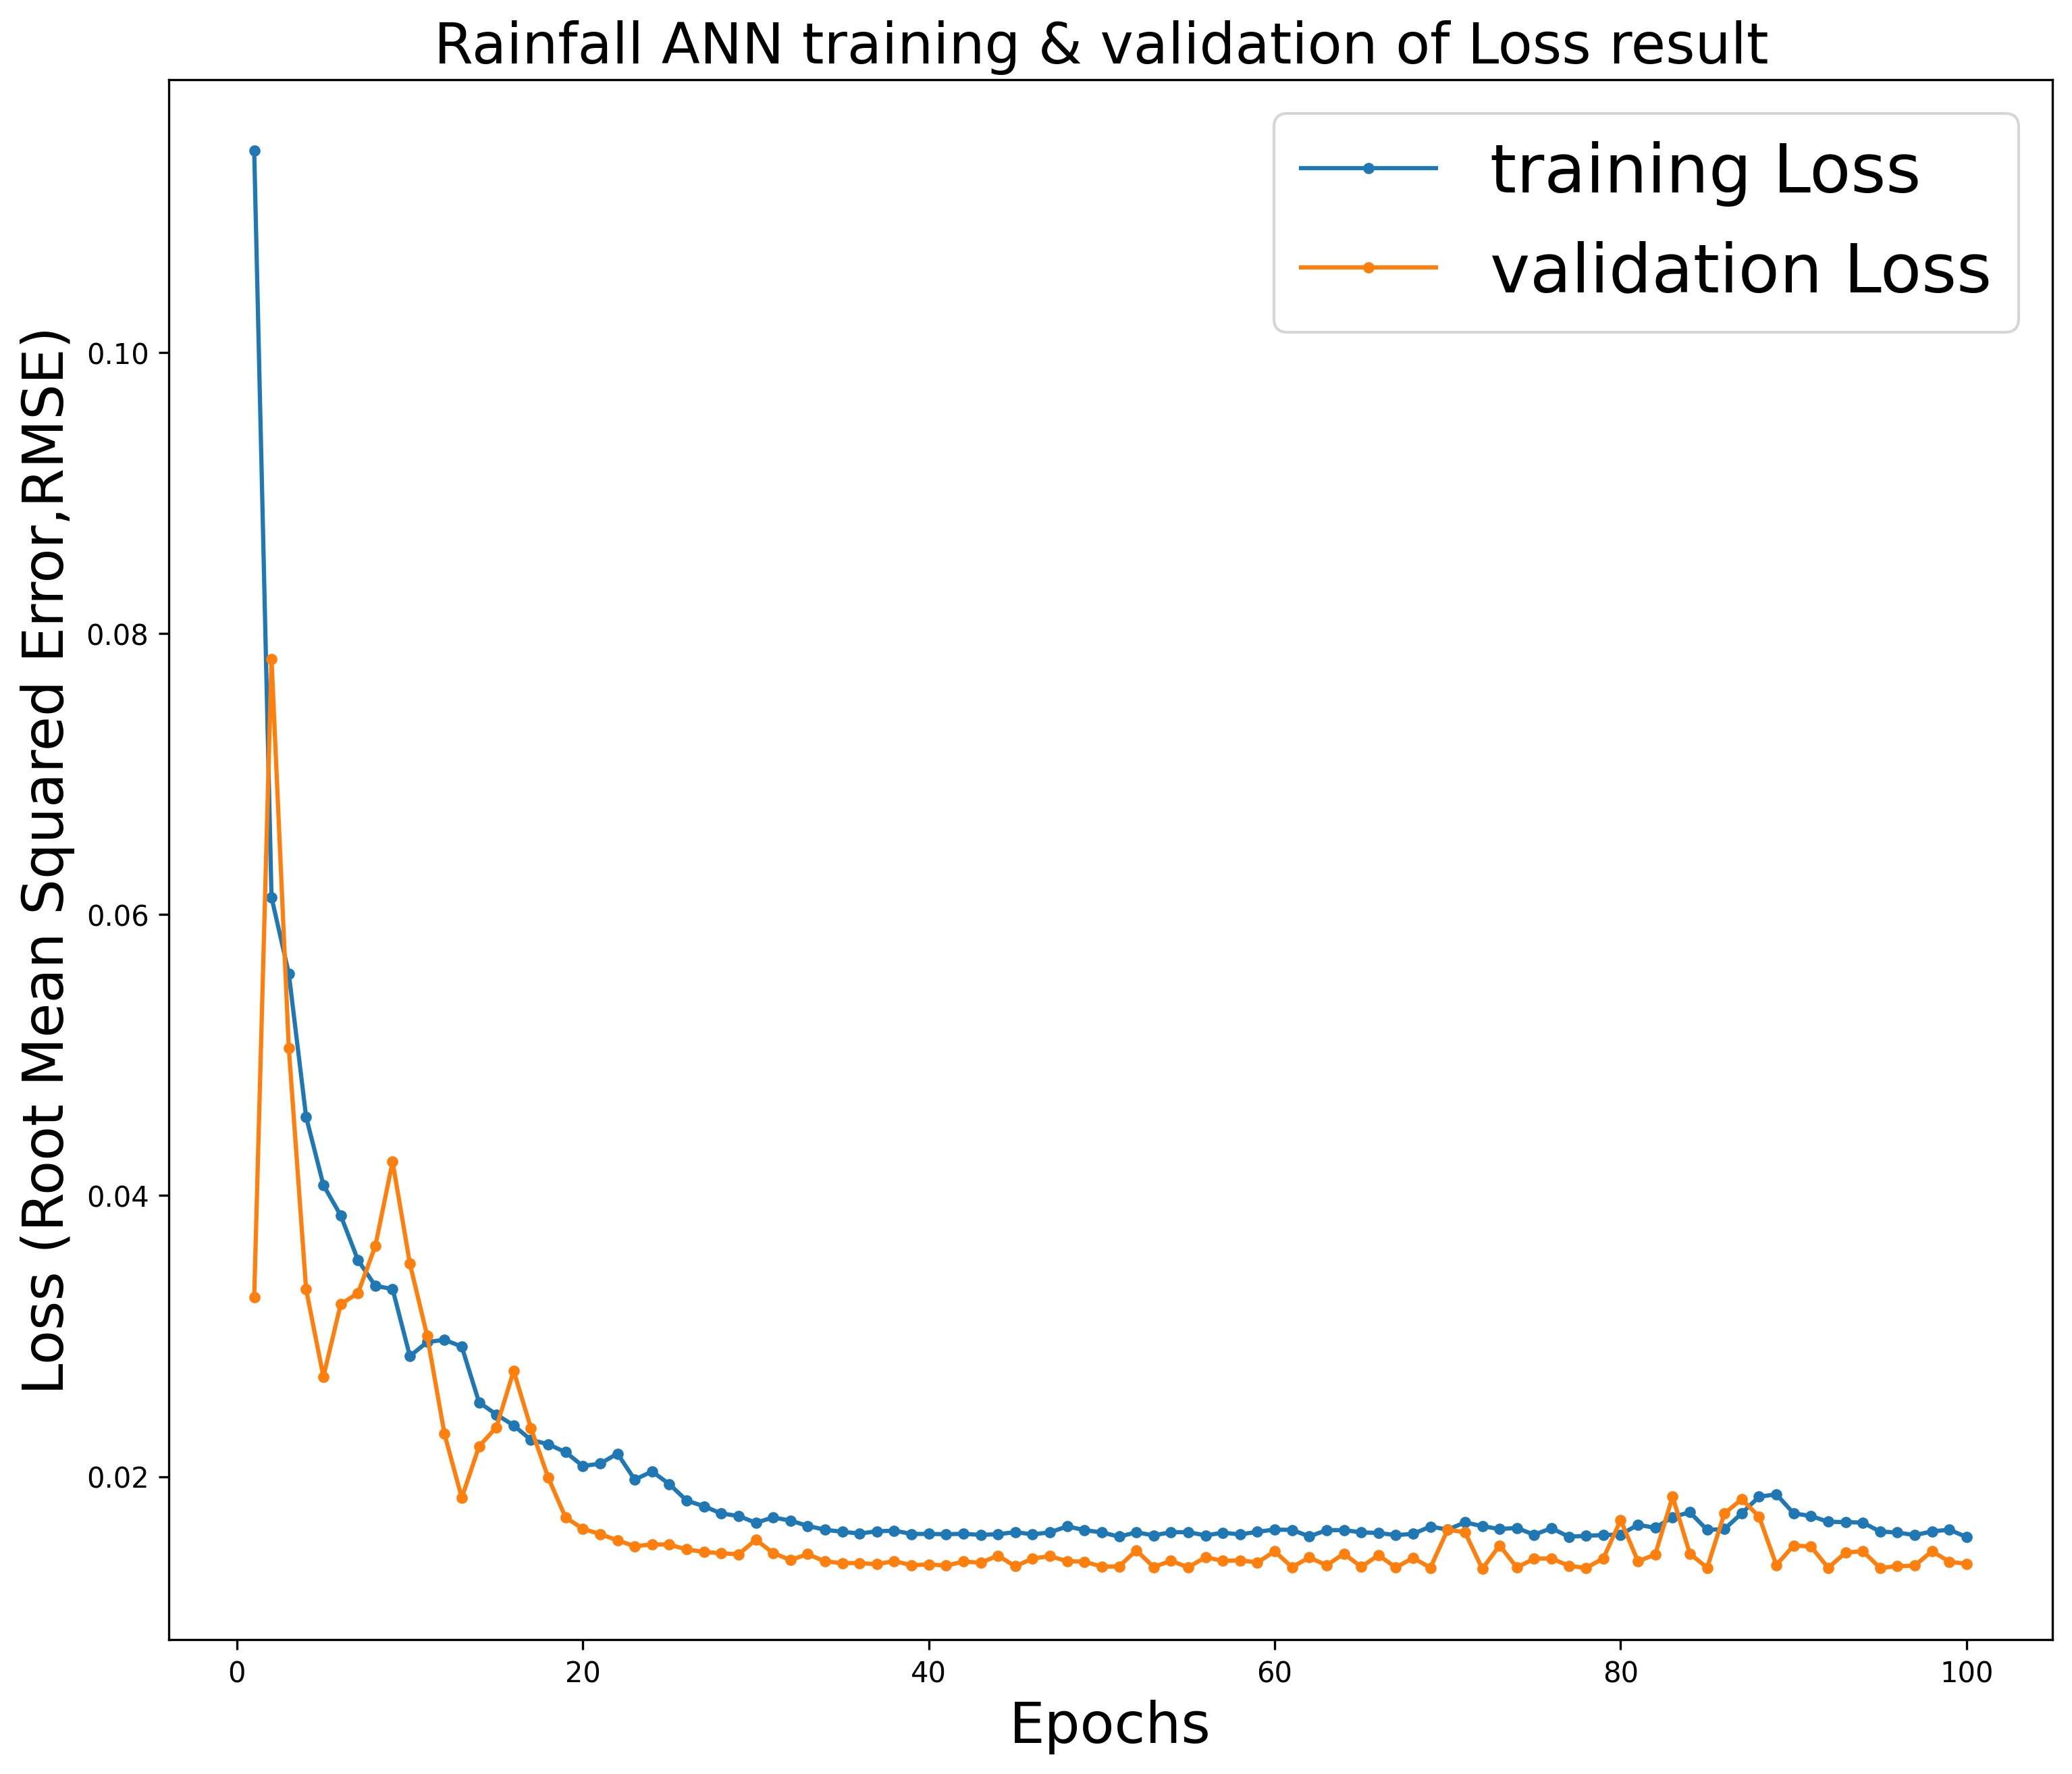

In [ ]:
# Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
model.save('RNN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
RNN_model=keras.models.load_model('RNN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# Testing

In [ ]:
# Predict
predicted_price = RNN_model.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_price = sc.inverse_transform(predicted_price)
actual_price = sc.inverse_transform(y_test)
predicted_price

8/8 [==============================] - 0s 2ms/step


array([[15.15691  ],
       [15.135757 ],
       [15.310311 ],
       [15.455139 ],
       [15.3655405],
       [15.364316 ],
       [15.351646 ],
       [15.885788 ],
       [15.731829 ],
       [15.938327 ],
       [16.282305 ],
       [16.3455   ],
       [16.632656 ],
       [17.001875 ],
       [16.995676 ],
       [16.882462 ],
       [16.913668 ],
       [16.755995 ],
       [16.845543 ],
       [16.66148  ],
       [16.819942 ],
       [16.795225 ],
       [17.223284 ],
       [17.19464  ],
       [17.513145 ],
       [17.972115 ],
       [17.97611  ],
       [18.739246 ],
       [18.748178 ],
       [18.697586 ],
       [17.992472 ],
       [18.219282 ],
       [18.52417  ],
       [18.271442 ],
       [17.143251 ],
       [17.223902 ],
       [16.471306 ],
       [16.735338 ],
       [16.70375  ],
       [16.743694 ],
       [16.814495 ],
       [16.790592 ],
       [16.622402 ],
       [16.51253  ],
       [16.379086 ],
       [16.29812  ],
       [16.457047 ],
       [17.22

In [ ]:
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('output.csv', index=False)

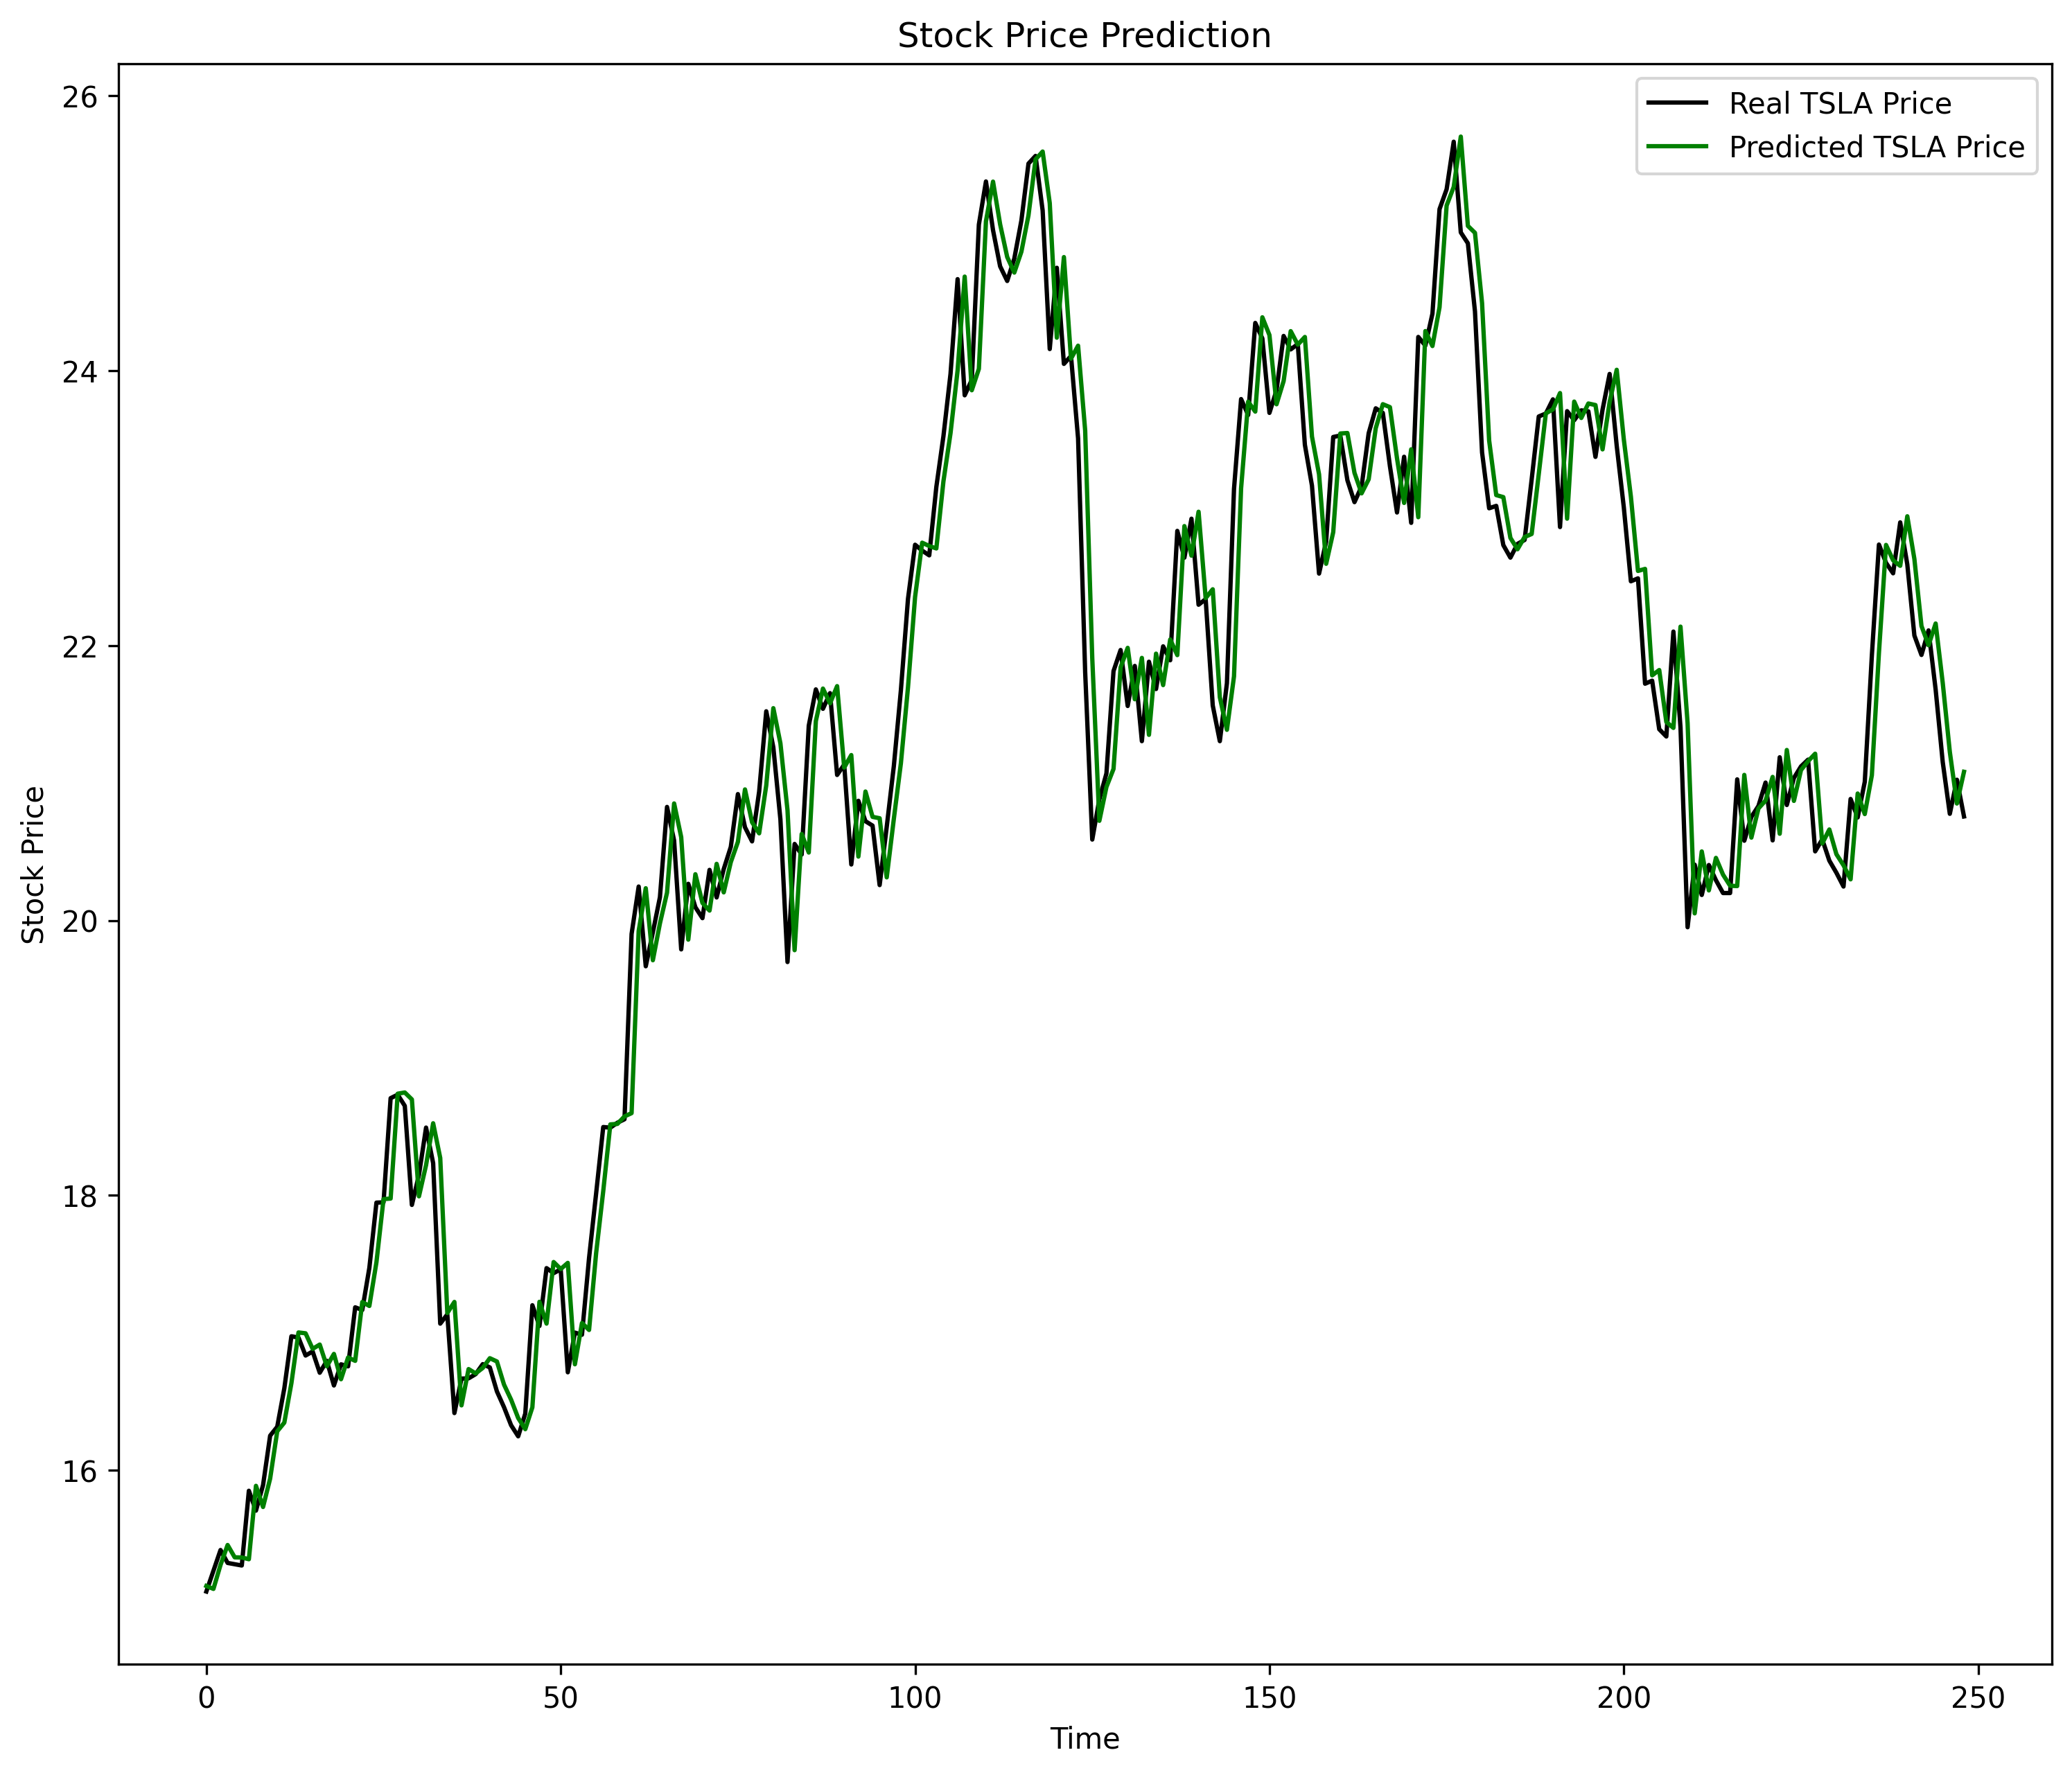

In [ ]:
plt.figure(figsize=(12,10),dpi=300)
plt.plot(actual_price, color = 'black', label = 'Real TSLA Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted TSLA Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
predicted_price
actual_price

MAE=mean_absolute_error(actual_price,predicted_price)
MSE=mean_squared_error(actual_price,predicted_price,squared=True)
RMSE=mean_squared_error(actual_price,predicted_price,squared=False)
# MAPE=mean_absolute_percentage_error(actual_price,predicted_price)
SMAPE=SMAPE_calulate(actual_price,predicted_price)
# RAE=RAE_calculate(actual_price,predicted_price)
# MRAE=MRAE_calculate(actual_price,predicted_price)
MdRAE=MdRAE_calculate(actual_price,predicted_price)
# RSE=RSE_calculate(actual_price,predicted_price,Root=False)
# RRSE=RSE_calculate(actual_price,predicted_price,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
# print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
# print('RAE:',round(RAE,3))
# print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# print('RSE:',round(RSE,3))
# print('RRSE:',round(RRSE,3))

MAE: 0.353
MSE: 0.224
RMSE: 0.473
SMAPE: 1.667 %
MdRAE: 0.174 bench: 21.004


# Naive

In [ ]:
# Naive
predicted_price = data[1009:-1].values.reshape(-1,1)
actual_price = sc.inverse_transform(y_test)

MAE=mean_absolute_error(actual_price,predicted_price)
MSE=mean_squared_error(actual_price,predicted_price,squared=True)
RMSE=mean_squared_error(actual_price,predicted_price,squared=False)
SMAPE=SMAPE_calulate(actual_price,predicted_price)
MdRAE=MdRAE_calculate(actual_price,predicted_price)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('SMAPE:',round(SMAPE,3),'%')
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))

MAE: 0.353
MSE: 0.222
RMSE: 0.471
SMAPE: 1.665 %
MdRAE: 0.165 bench: 21.004


In [ ]:
# Naive
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('Naive_output.csv', index=False)

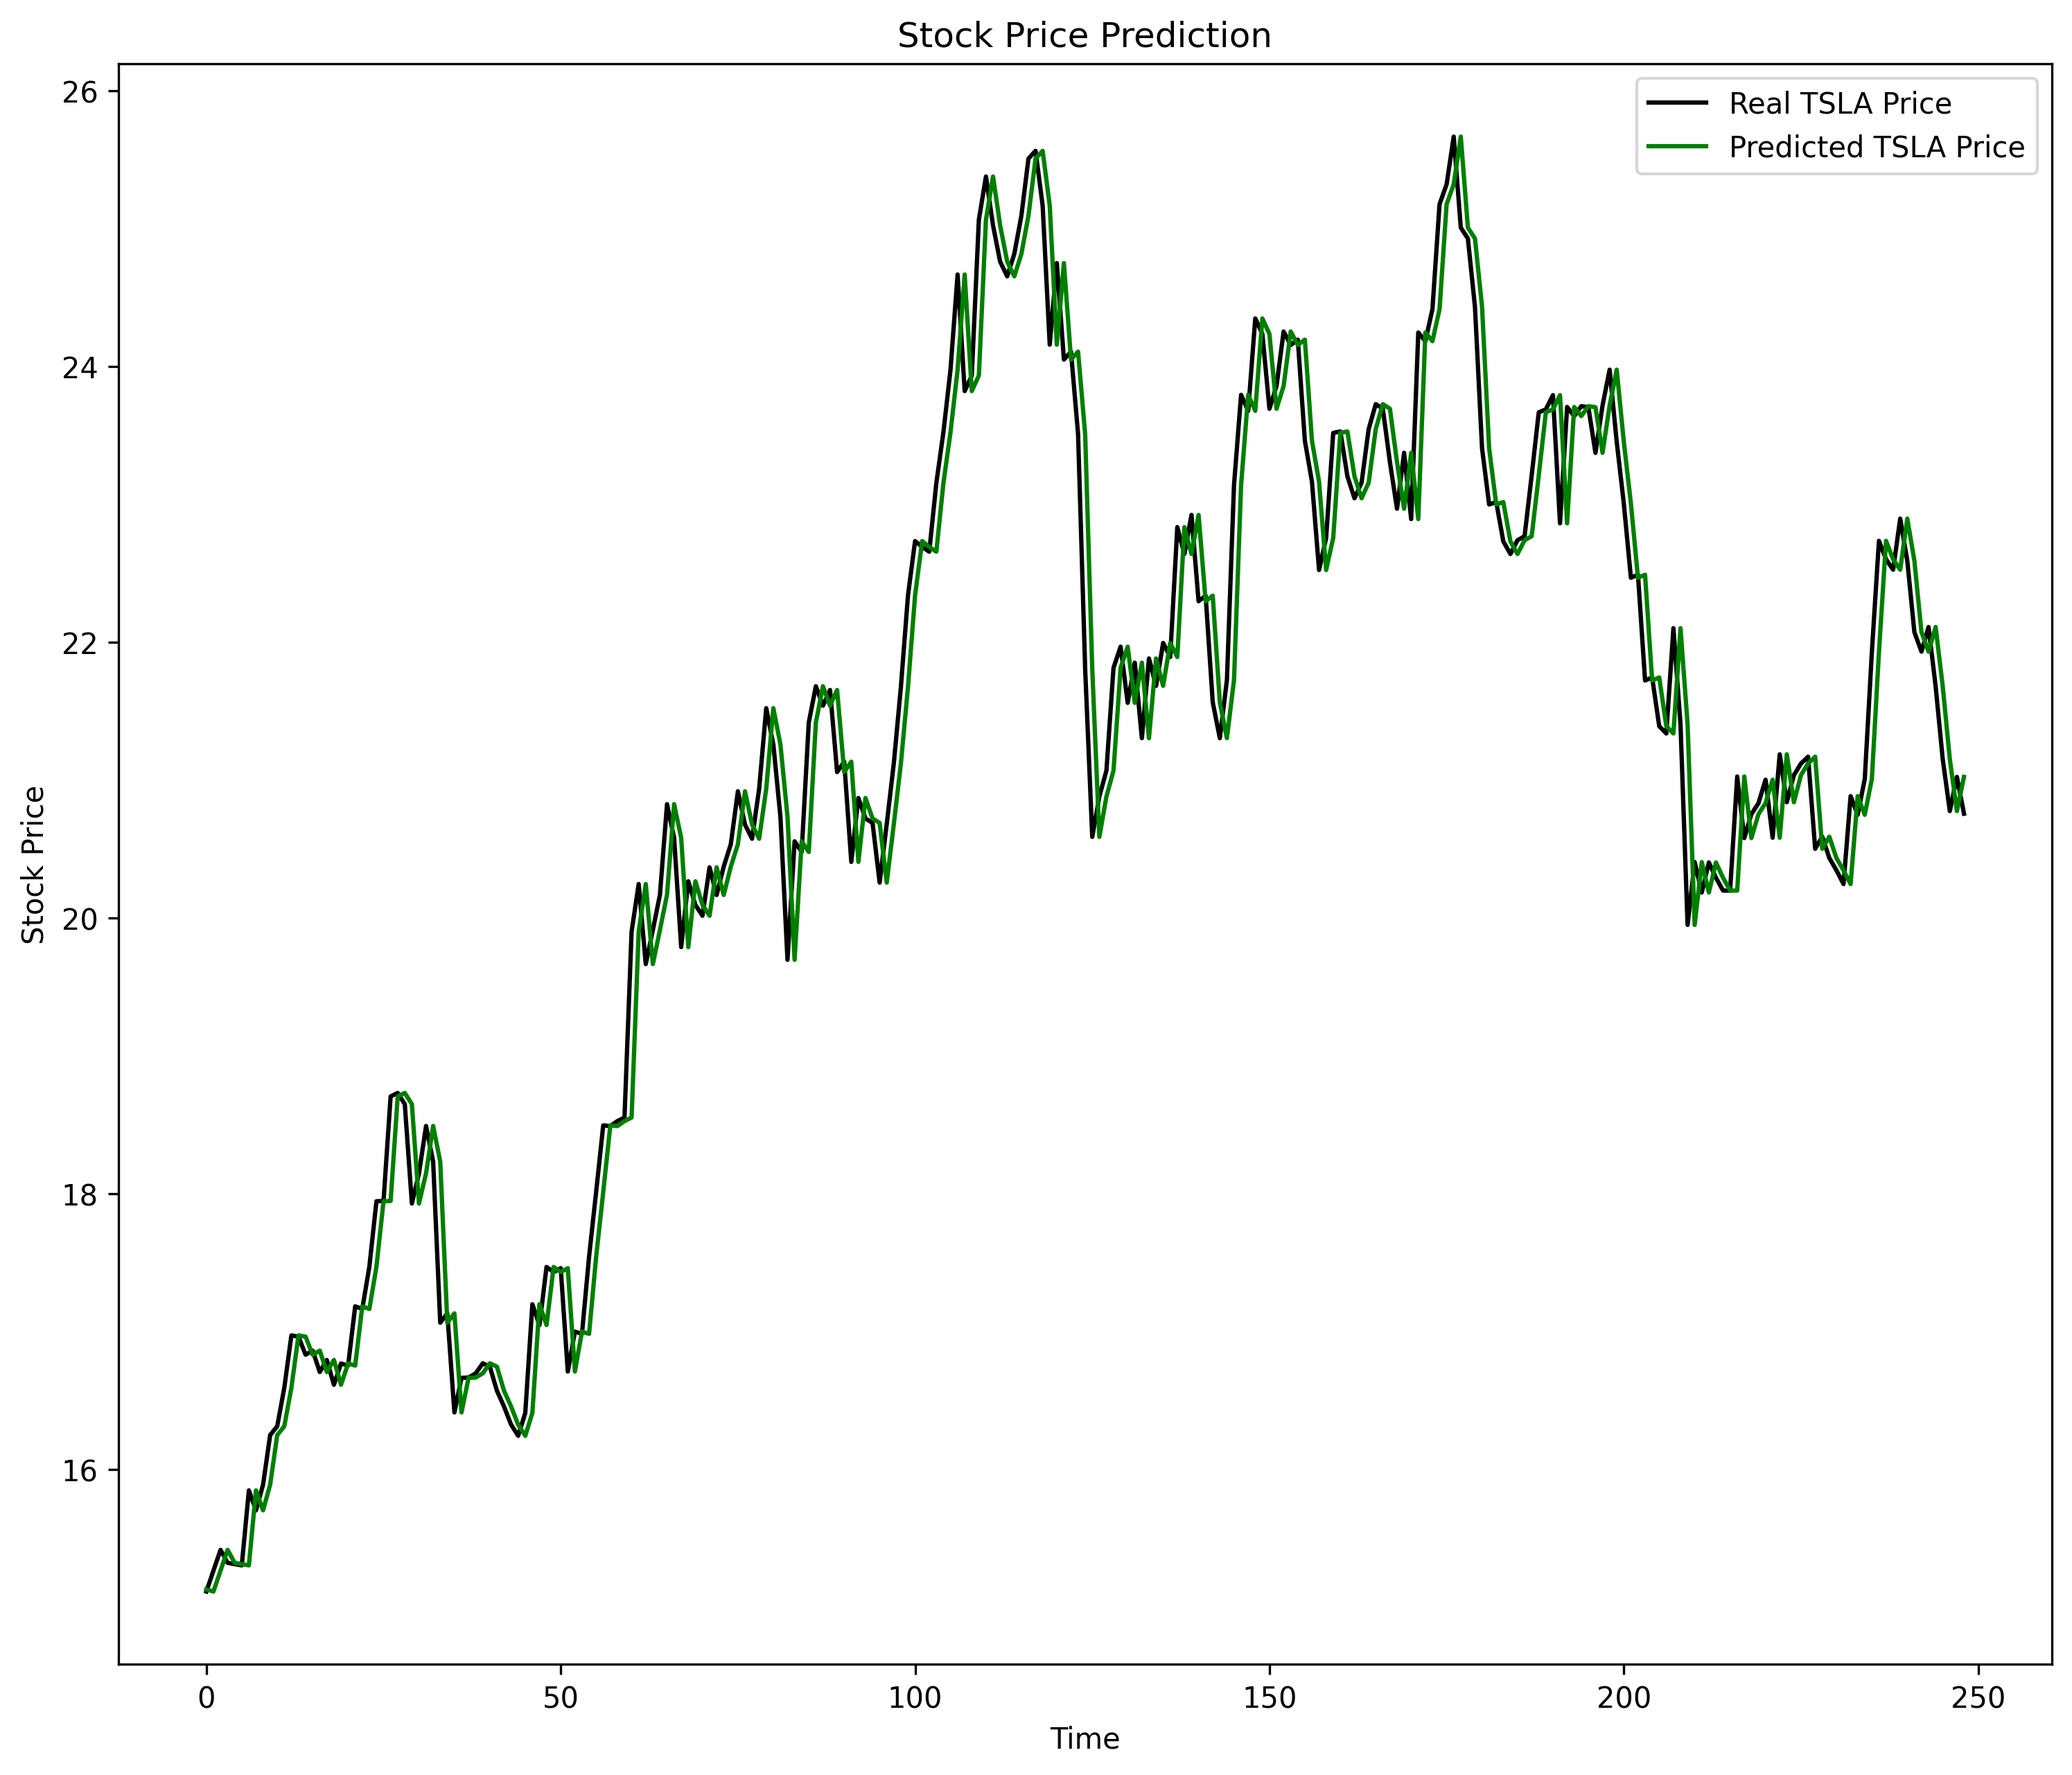

In [ ]:
plt.figure(figsize=(12,10),dpi=300)
plt.plot(actual_price, color = 'black', label = 'Real TSLA Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted TSLA Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# LSTM

## Build model & Compile & Fit

In [ ]:
# 一層
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units = 64,input_shape = (X_train.shape[1], 1)))
model.add(Dense(1,activation='linear'))
model.summary()
opt=Adam(learning_rate=0.008,beta_1=0.99)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 兩層
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], 1), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1,activation='linear'))
model.summary()
opt=Adam(learning_rate=0.01,beta_1=0.99)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 三層
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences = True))
model.add(LSTM(48,activation='relu', return_sequences = True))
model.add(LSTM(32,activation='relu'))
model.add(Dense(1,activation='linear'))
model.summary()
opt=Adam(learning_rate=0.01,beta_1=0.99)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 3, 48)             21696     
                                                                 
 lstm_2 (LSTM)               (None, 32)                10368     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 48,993
Trainable params: 48,993
Non-trainable params: 0
_________________________________________________________________


## Plot the history of training and validation

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64,validation_data=(X_val,y_val))

Epoch 1/100
13/13 [==============================] - 4s 51ms/step - loss: 0.2286 - mean_absolute_percentage_error: 68767.1016 - val_loss: 0.1879 - val_mean_absolute_percentage_error: 25.9806
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1265 - mean_absolute_percentage_error: 201176.0469 - val_loss: 0.1258 - val_mean_absolute_percentage_error: 17.9187
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0938 - mean_absolute_percentage_error: 159089.8906 - val_loss: 0.1147 - val_mean_absolute_percentage_error: 15.8416
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0718 - mean_absolute_percentage_error: 100041.2188 - val_loss: 0.0771 - val_mean_absolute_percentage_error: 10.9638
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0537 - mean_absolute_percentage_error: 89436.1094 - val_loss: 0.0482 - val_mean_absolute_percentage_error: 6.6501
Epoch 6/100
13/13 [============================

In [ ]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

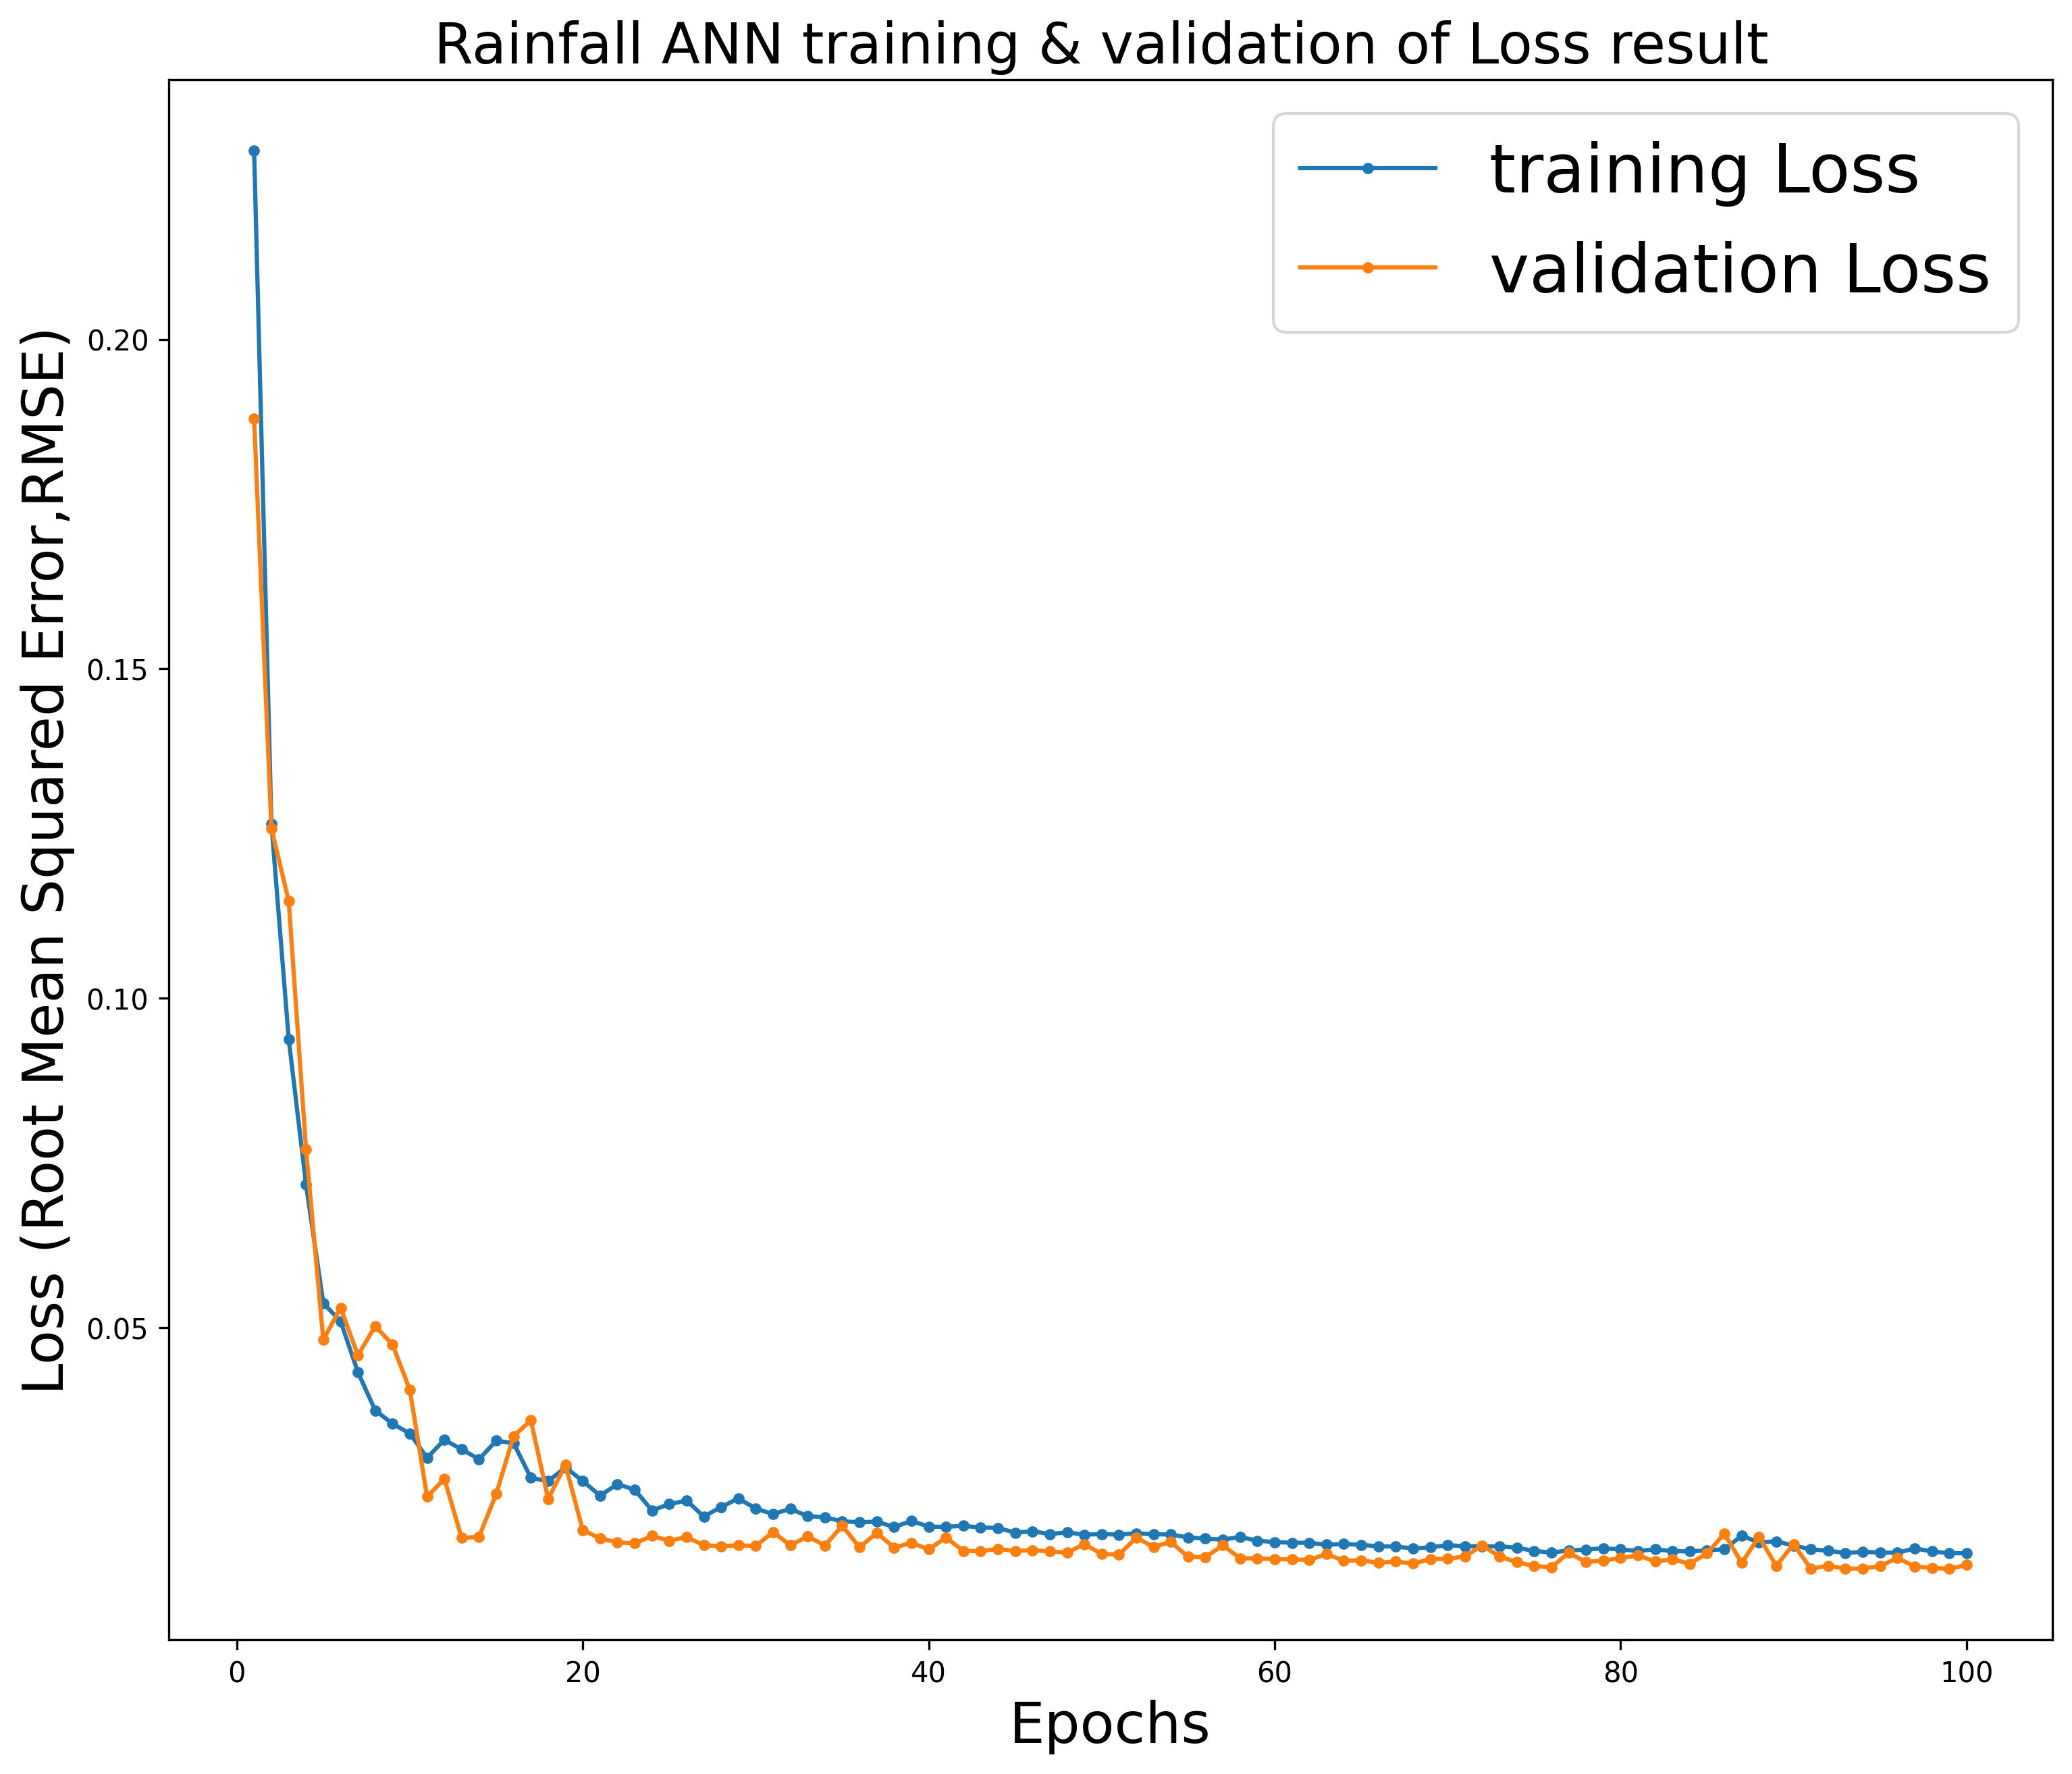

In [ ]:
# Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
model.save('RNN_LSTM_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
LSTM_model=keras.models.load_model('RNN_LSTM_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


## Testing

In [ ]:
predicted_price = LSTM_model.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_price = sc.inverse_transform(predicted_price)
actual_price = sc.inverse_transform(y_test)

8/8 [==============================] - 0s 2ms/step


In [ ]:
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('output2.csv', index=False)

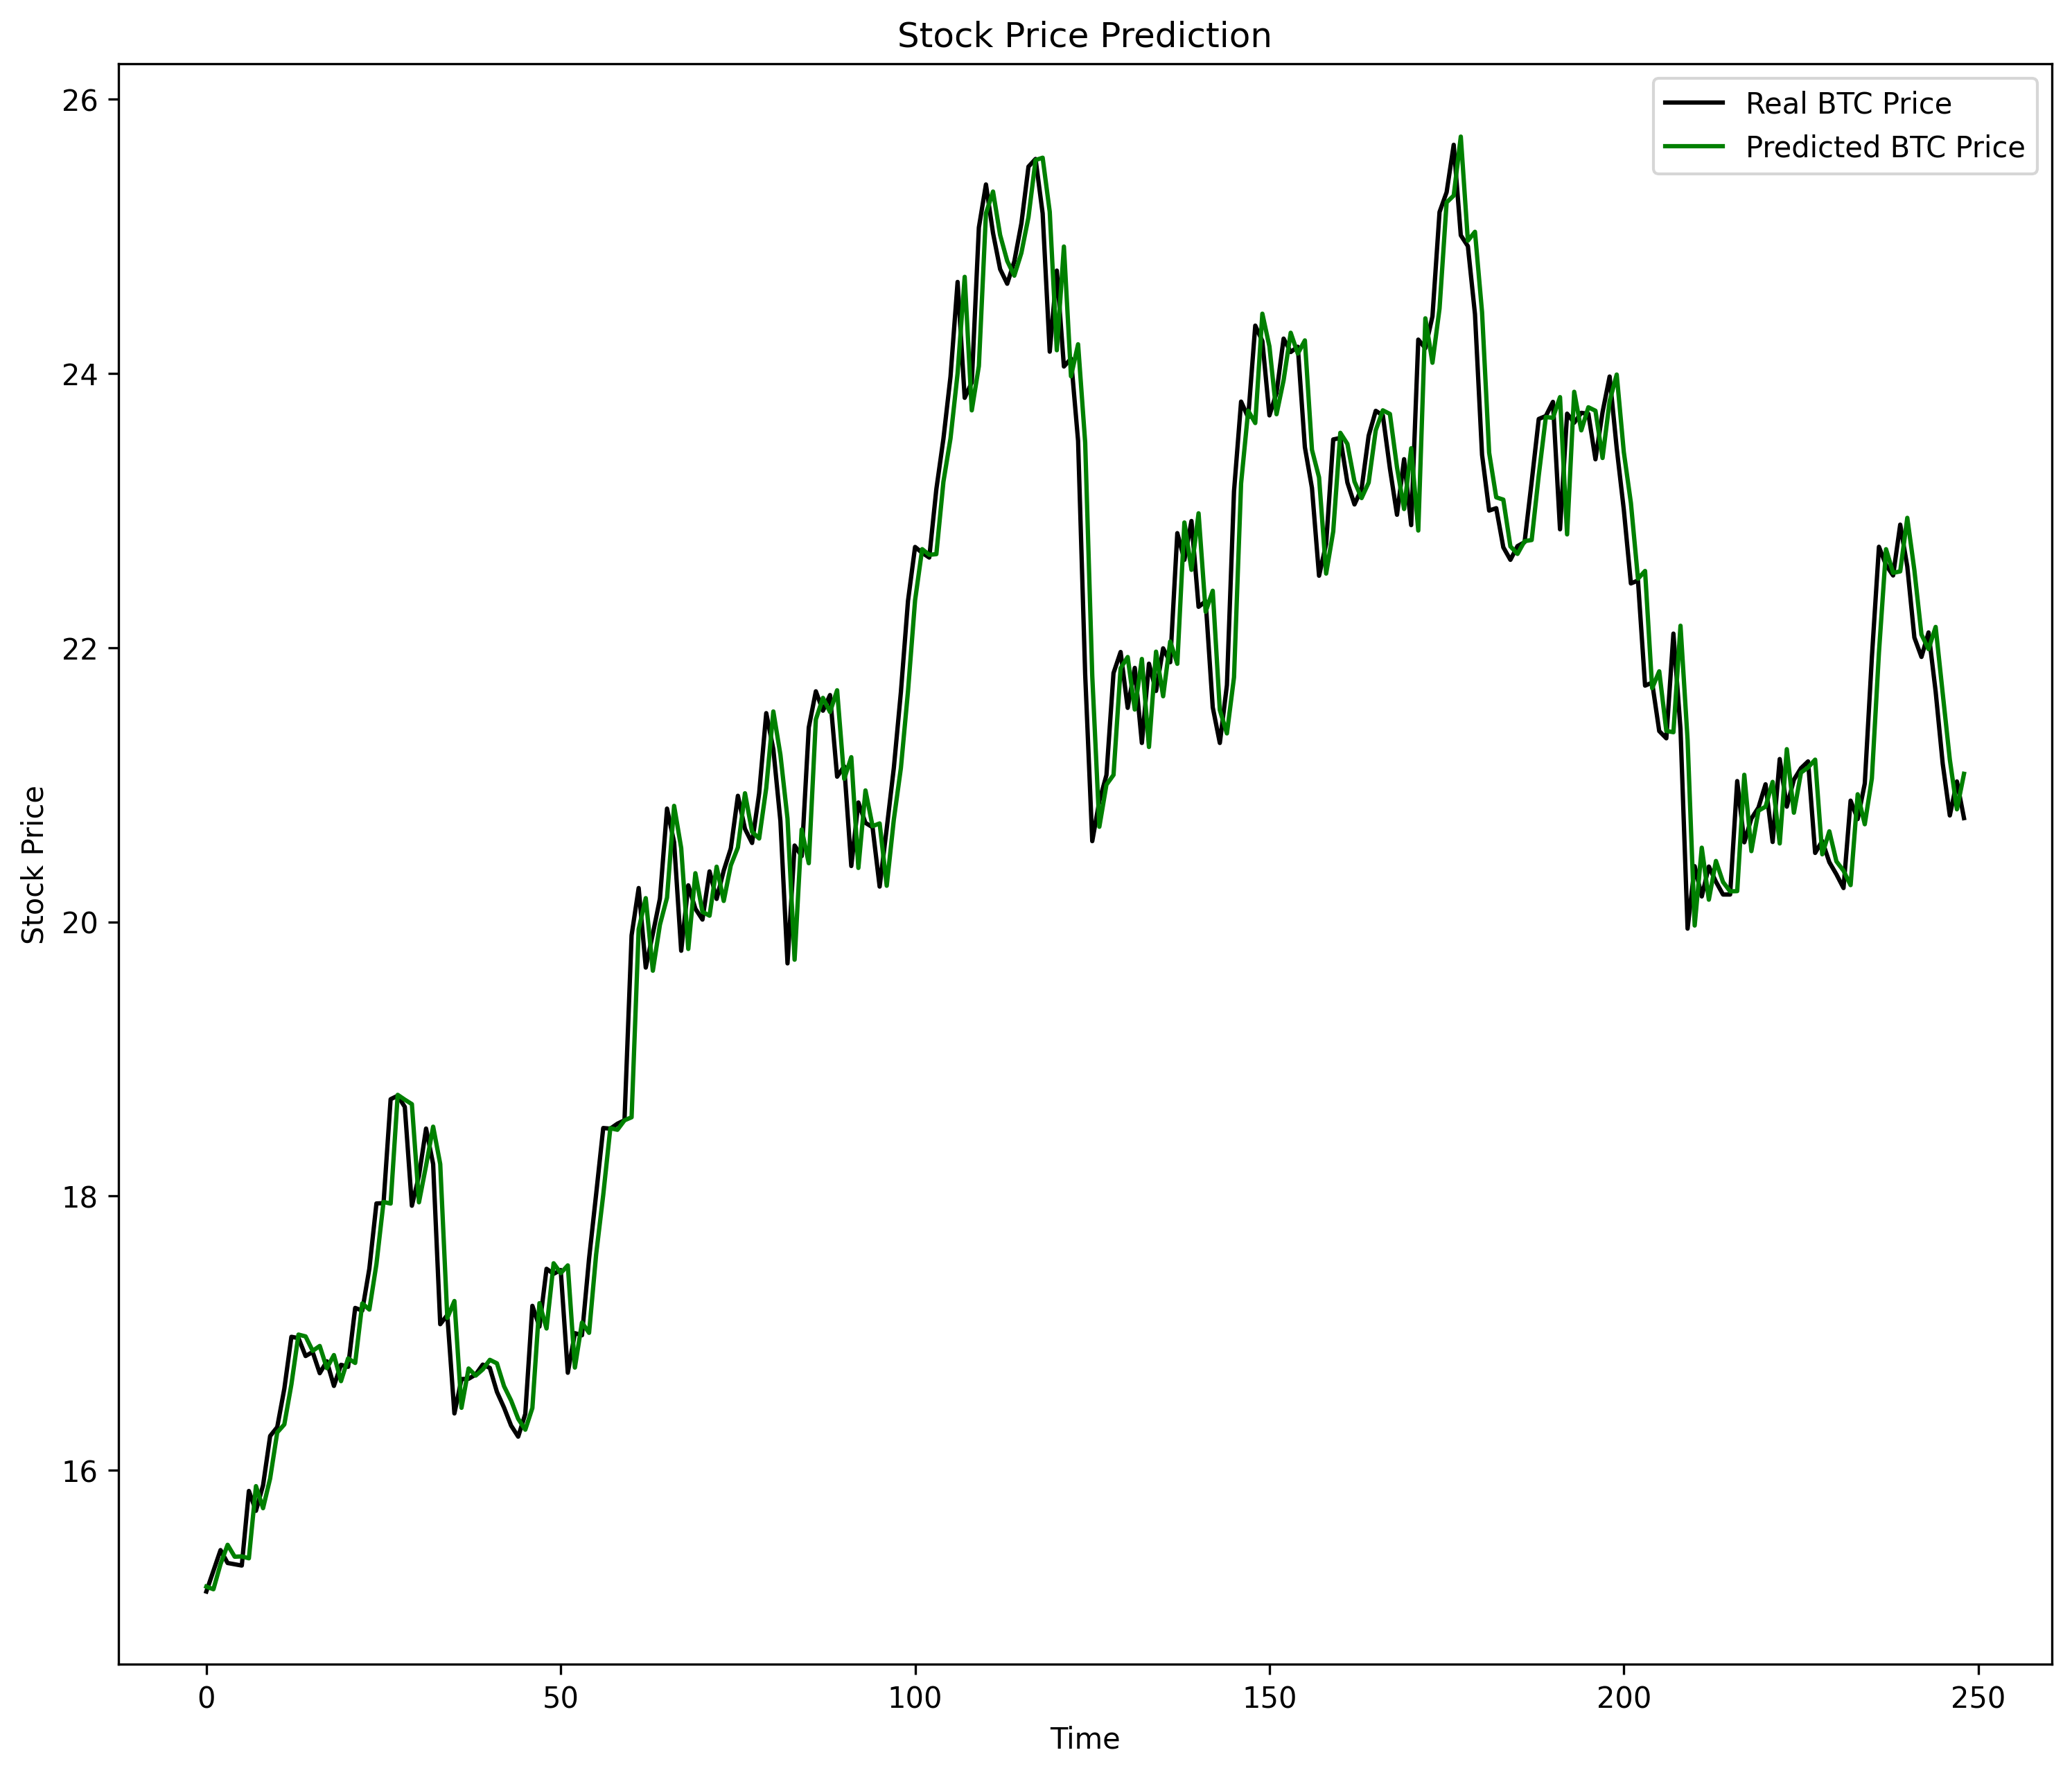

In [ ]:
plt.figure(figsize=(12,10),dpi=300)
plt.plot(actual_price, color = 'black', label = 'Real BTC Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted BTC Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
predicted_price
actual_price

MAE=mean_absolute_error(actual_price,predicted_price)
MSE=mean_squared_error(actual_price,predicted_price,squared=True)
RMSE=mean_squared_error(actual_price,predicted_price,squared=False)
# MAPE=mean_absolute_percentage_error(actual_price,predicted_price)
SMAPE=SMAPE_calulate(actual_price,predicted_price)
# RAE=RAE_calculate(actual_price,predicted_price)
# MRAE=MRAE_calculate(actual_price,predicted_price)
MdRAE=MdRAE_calculate(actual_price,predicted_price)
# RSE=RSE_calculate(actual_price,predicted_price,Root=False)
# RRSE=RSE_calculate(actual_price,predicted_price,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
# print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
# print('RAE:',round(RAE,3))
# print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# print('RSE:',round(RSE,3))
# print('RRSE:',round(RRSE,3))

MAE: 0.357
MSE: 0.224
RMSE: 0.473
SMAPE: 1.683 %
MdRAE: 0.176 bench: 21.004


# GRU

## Fit & compile the model

In [313]:
# 一層
keras.backend.clear_session()
model = keras.models.Sequential([
    GRU(64, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
opt=Adam(learning_rate=0.006,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________


In [321]:
# 兩層
keras.backend.clear_session()
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dense(units=1))
opt=Adam(learning_rate=0.006,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 64)             12864     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 三層
keras.backend.clear_session()
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dense(units=1))
opt = Adam(learning_rate=0.005, beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 64)             12864     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 3, 64)             24960     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 62,849
Trainable params: 62,849
Non-traina

In [322]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 64,validation_data=(X_val,y_val))

Epoch 1/100
13/13 [==============================] - 6s 98ms/step - loss: 0.1434 - mean_absolute_percentage_error: 161981.2656 - val_loss: 0.0853 - val_mean_absolute_percentage_error: 11.8375
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0561 - mean_absolute_percentage_error: 65520.0703 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 2.5867
Epoch 3/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0364 - mean_absolute_percentage_error: 15204.8525 - val_loss: 0.0196 - val_mean_absolute_percentage_error: 2.7738
Epoch 4/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0356 - mean_absolute_percentage_error: 4202.1860 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 3.9306
Epoch 5/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0349 - mean_absolute_percentage_error: 20142.5430 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 3.0000
Epoch 6/100
13/13 [==============================

In [323]:
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

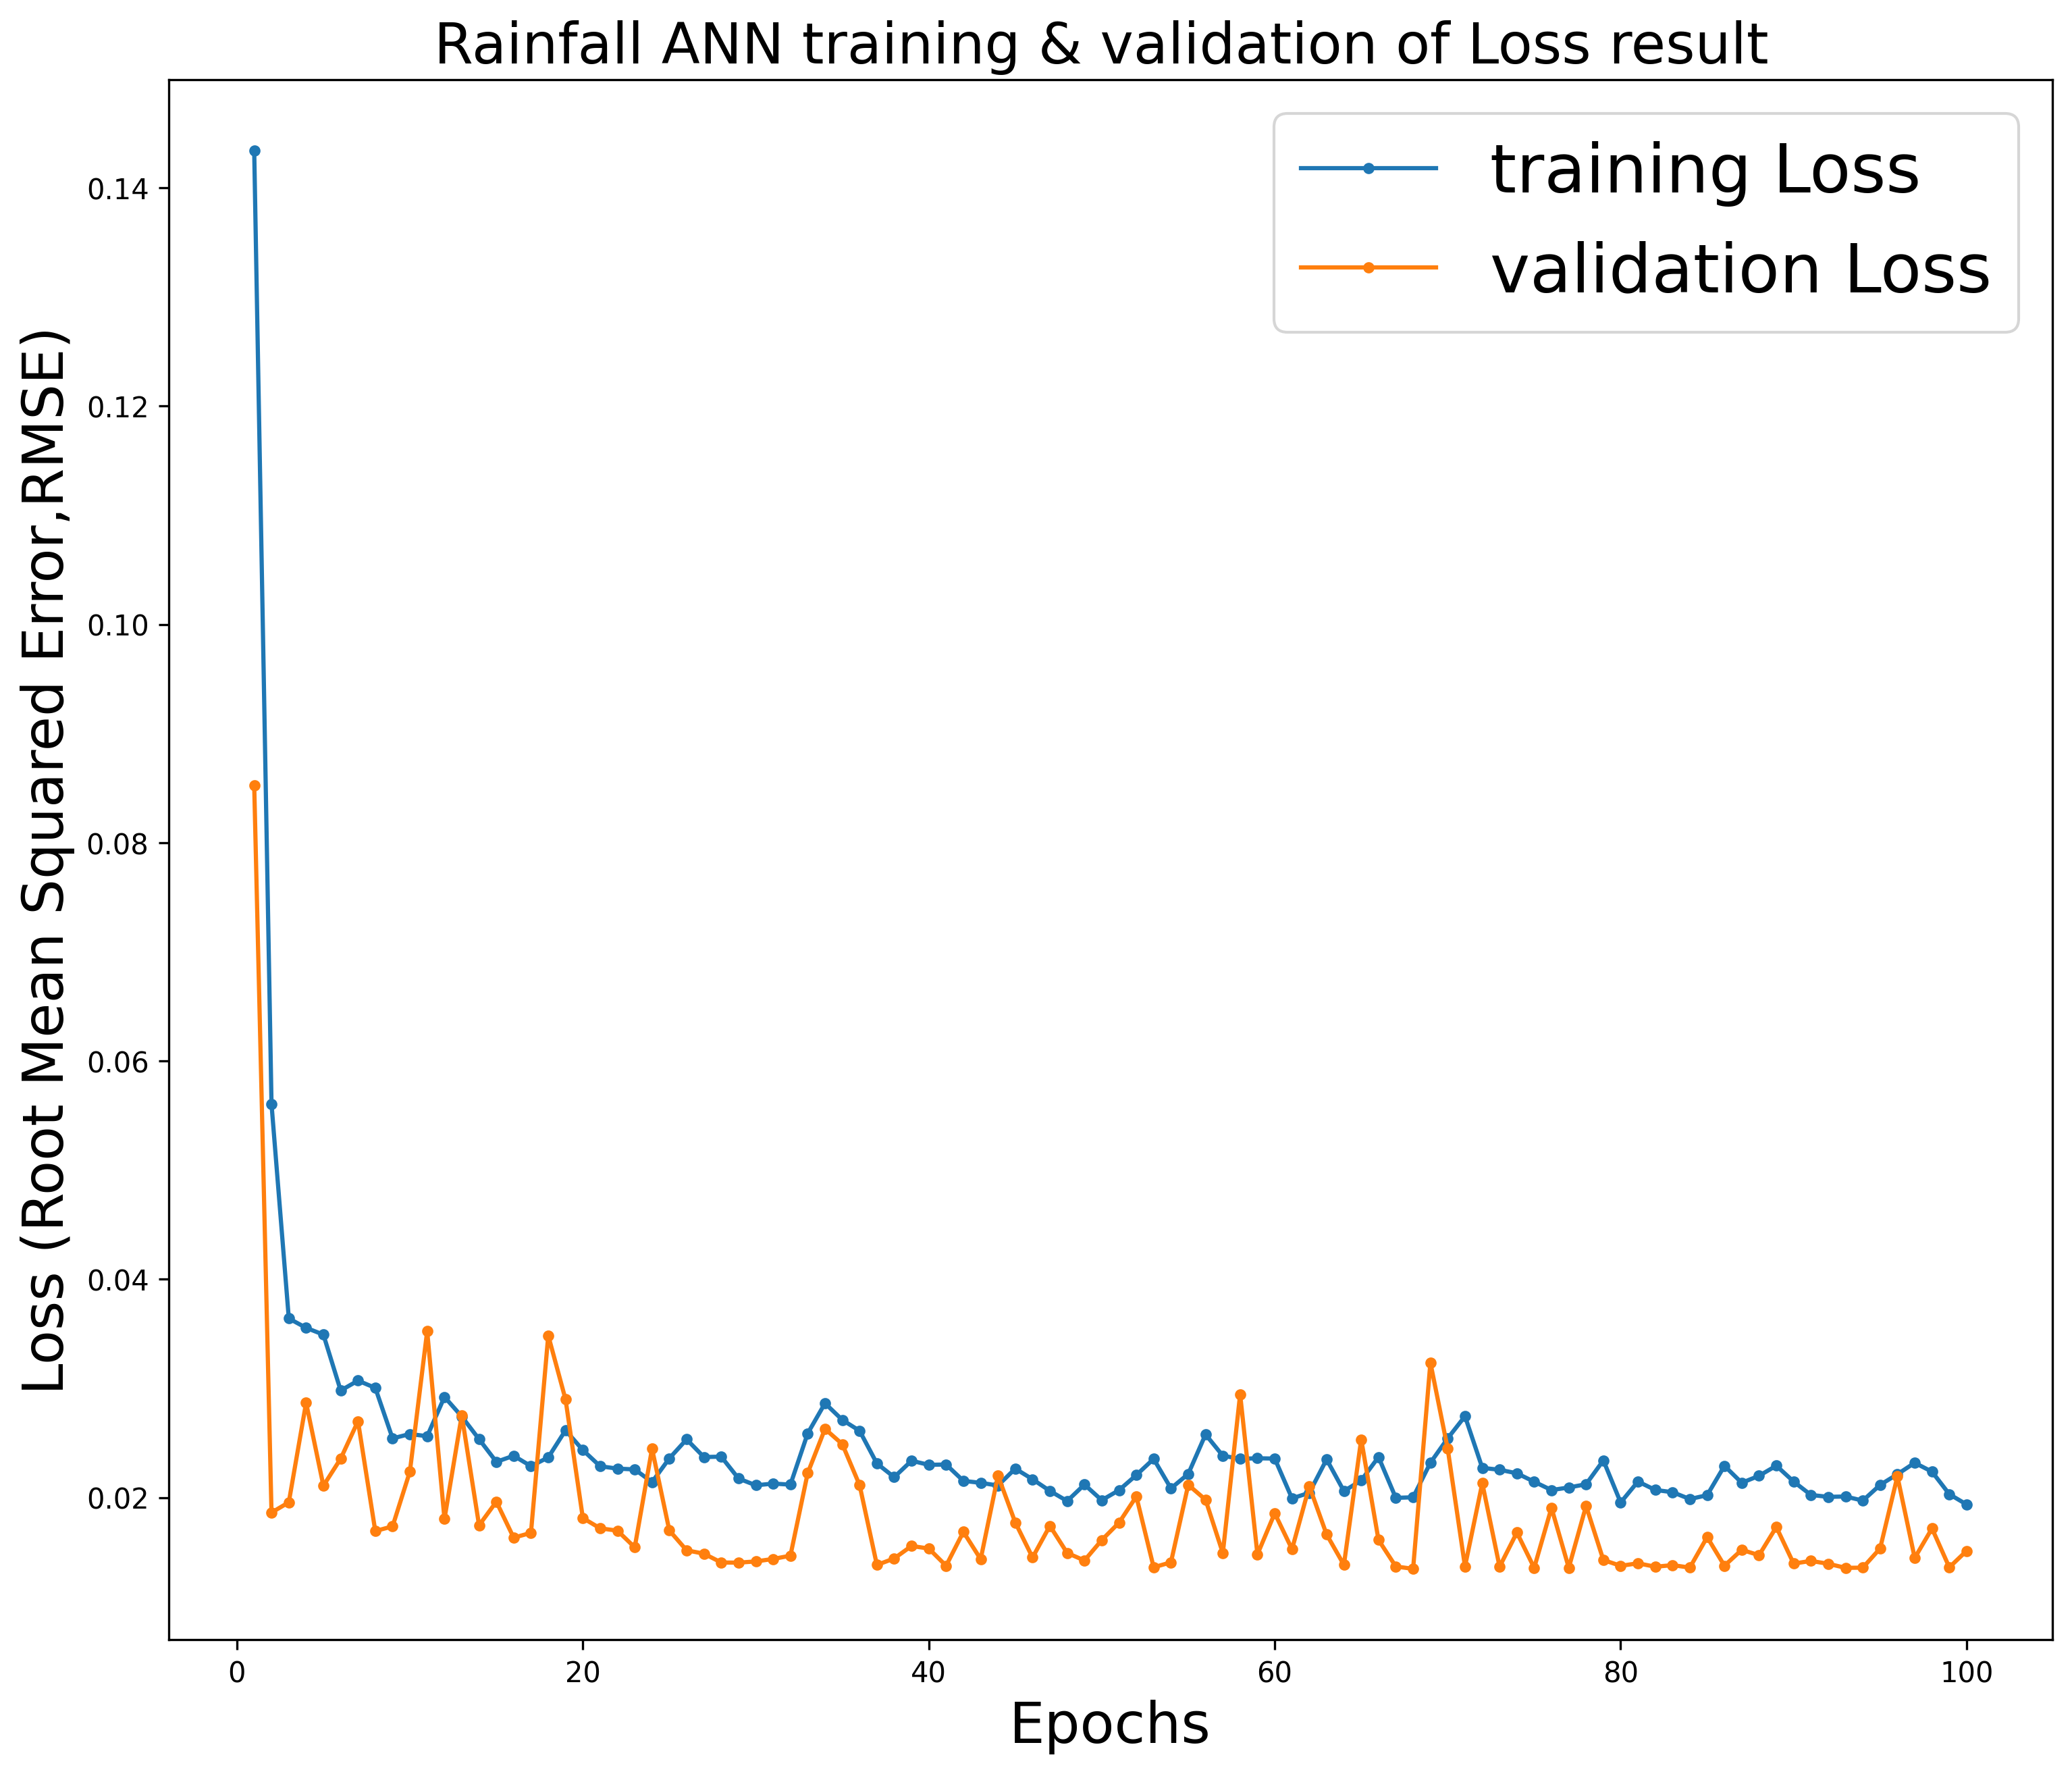

In [324]:
# Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

In [ ]:
model.save('RNN_GRU_trained_model1.h5')
print('Model has been saved...')

Model has been saved...


In [329]:
GRU_model=keras.models.load_model('RNN_GRU_trained_model1.h5')
print('Model successfully loaded...')

Model successfully loaded...


## Testing

In [330]:
predicted_price =GRU_model.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_price = sc.inverse_transform(predicted_price)
actual_price = sc.inverse_transform(y_test)

8/8 [==============================] - 4s 5ms/step


In [331]:
df1 = pd.DataFrame(predicted_price)
df2 = pd.DataFrame(actual_price)

df1.columns = ['Pred']
df2.columns = ['Actual']

merged_df = pd.concat([df1, df2], axis=1)
merged_df.to_csv('output.csv', index=False)

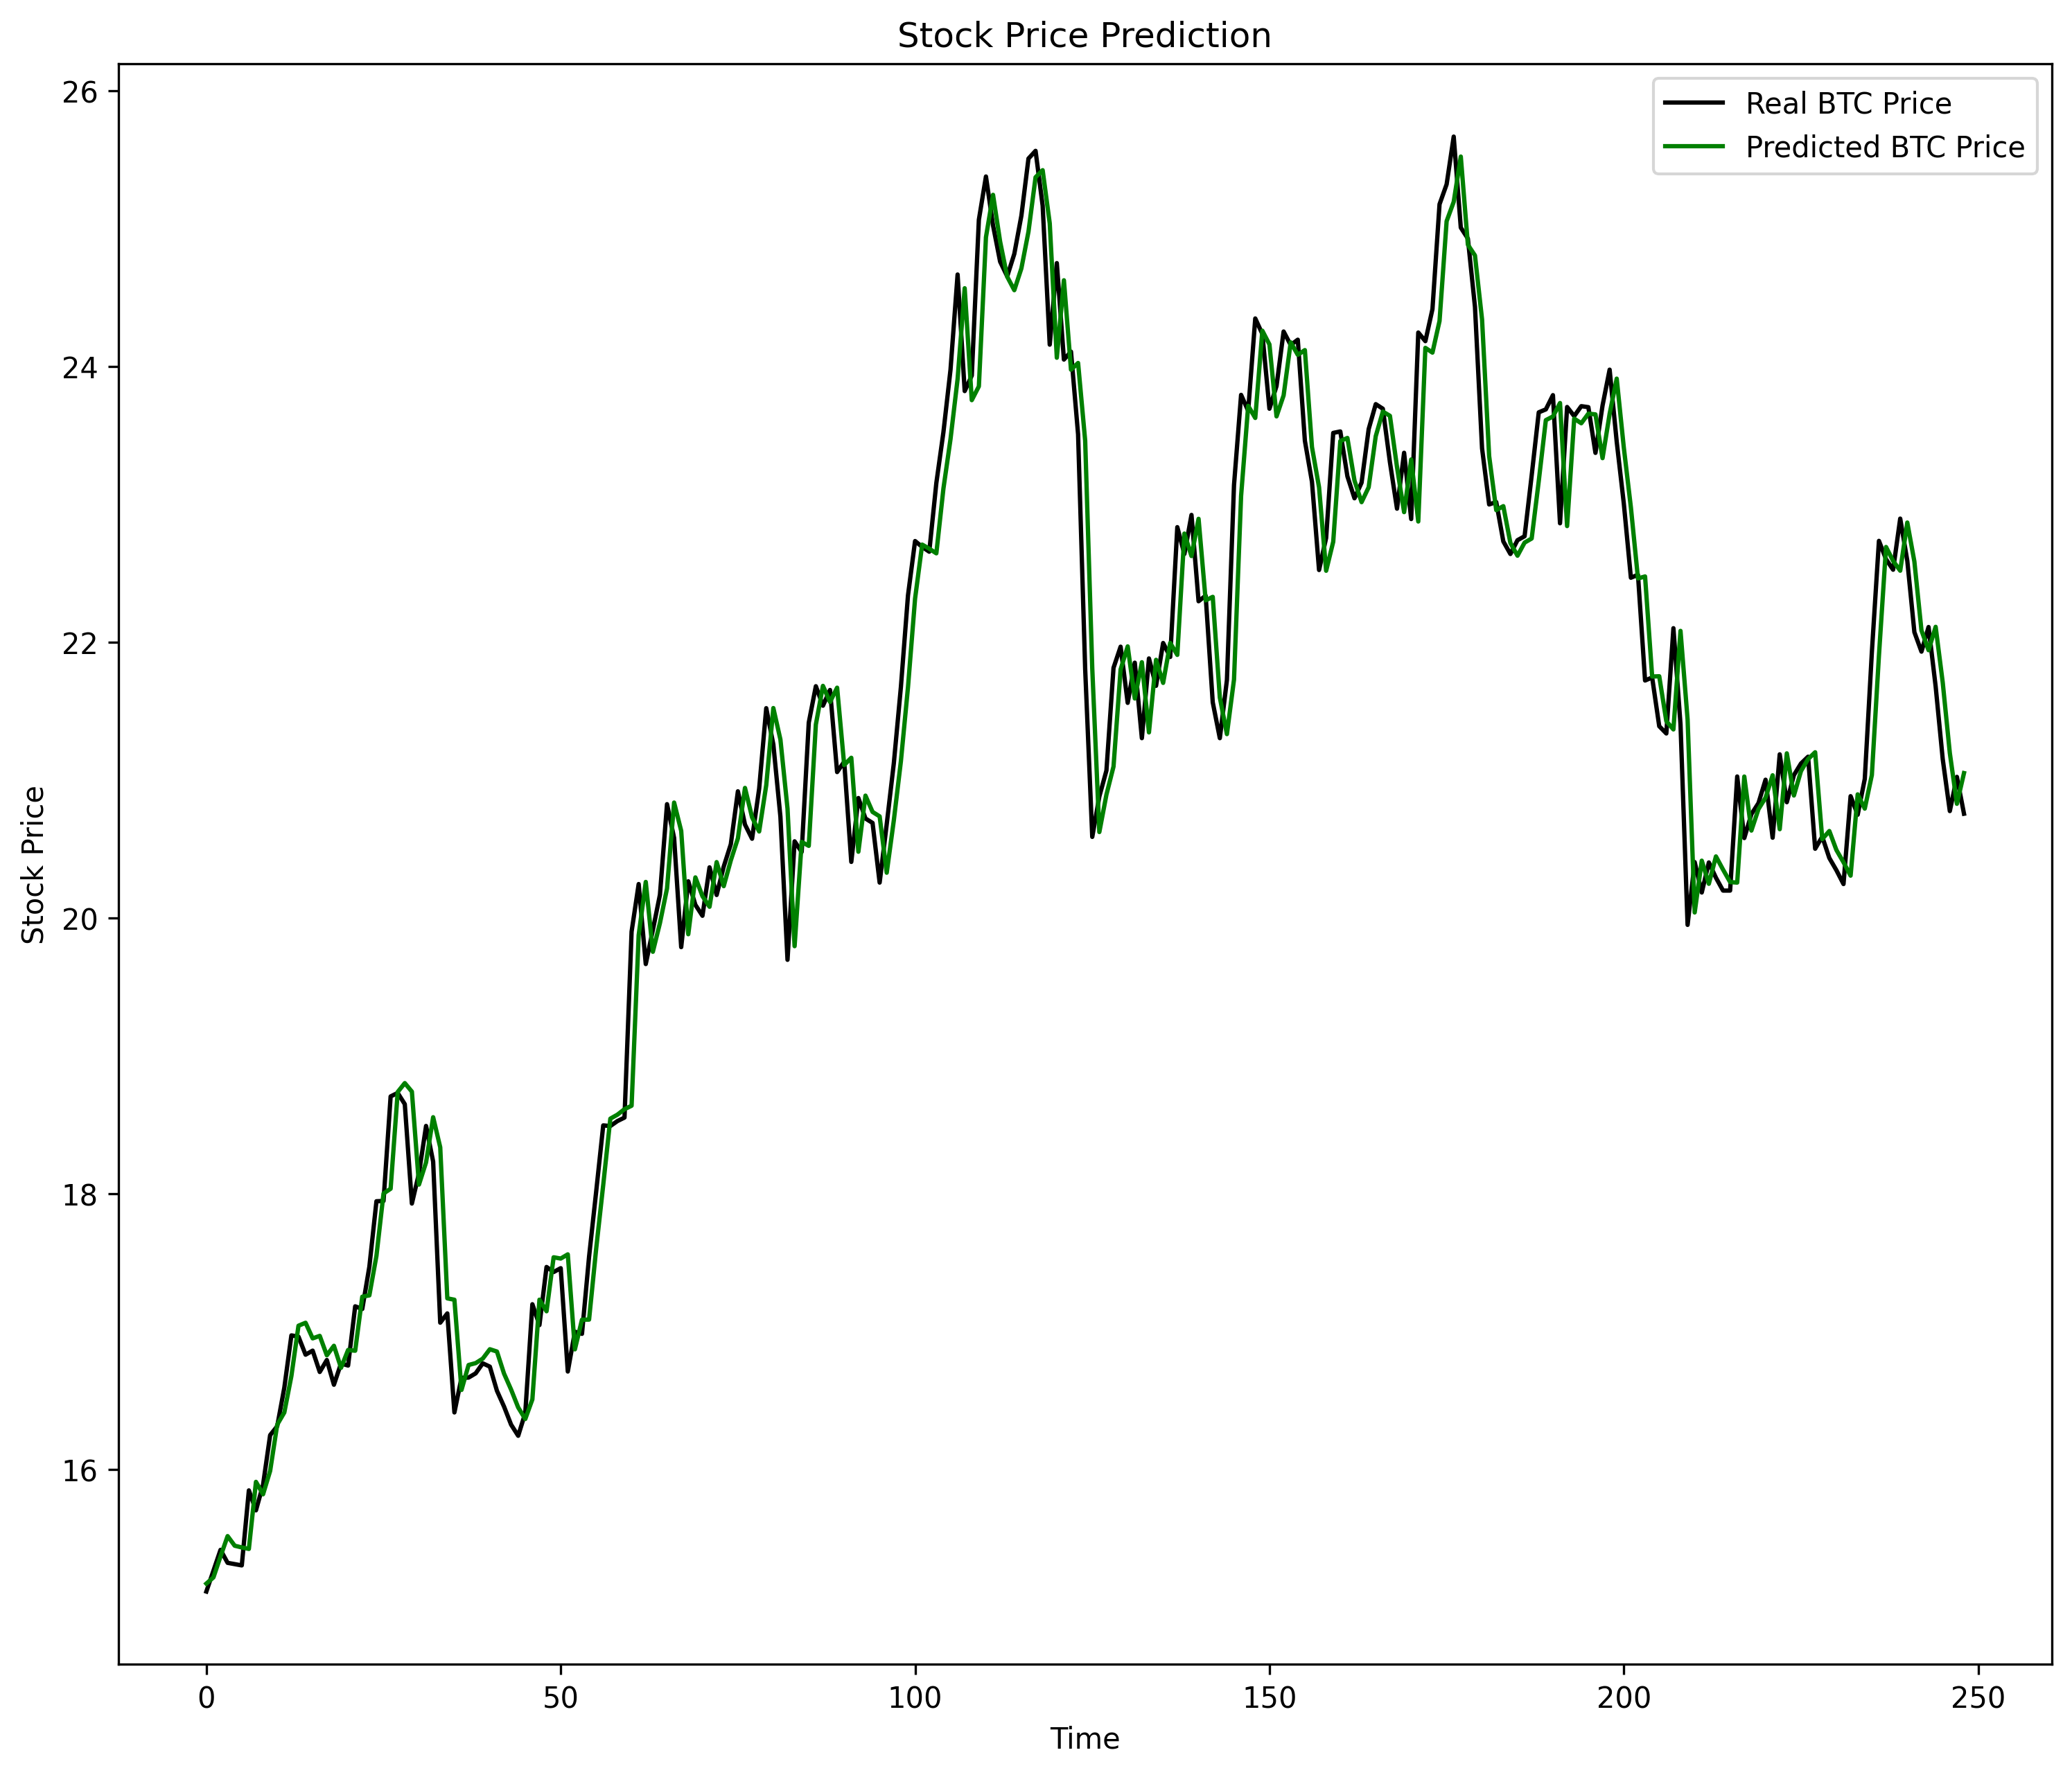

In [332]:
plt.figure(figsize=(12,10),dpi=300)
plt.plot(actual_price, color = 'black', label = 'Real BTC Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted BTC Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [333]:
predicted_price
actual_price

MAE=mean_absolute_error(actual_price,predicted_price)
MSE=mean_squared_error(actual_price,predicted_price,squared=True)
RMSE=mean_squared_error(actual_price,predicted_price,squared=False)
# MAPE=mean_absolute_percentage_error(actual_price,predicted_price)
SMAPE=SMAPE_calulate(actual_price,predicted_price)
# RAE=RAE_calculate(actual_price,predicted_price)
# MRAE=MRAE_calculate(actual_price,predicted_price)
MdRAE=MdRAE_calculate(actual_price,predicted_price)
# RSE=RSE_calculate(actual_price,predicted_price,Root=False)
# RRSE=RSE_calculate(actual_price,predicted_price,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
# print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
# print('RAE:',round(RAE,3))
# print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# print('RSE:',round(RSE,3))
# print('RRSE:',round(RRSE,3))

MAE: 0.349
MSE: 0.216
RMSE: 0.465
SMAPE: 1.65 %
MdRAE: 0.173 bench: 21.004
